# Table of Contents
* [Monitoring the photovoltaic energy production](#Monitoring-the-photovoltaic-energy-production)
	* [Load the data](#Load-the-data)
	* [Model of the data](#Model-of-the-data)
	* [Preprocessing](#Preprocessing)
	* [Phase I SPC: Estimation of the regular patterns](#Phase-I-SPC:-Estimation-of-the-regular-patterns)
		* [Selection of the pool of IC series](#Selection-of-the-pool-of-IC-series)
		* [Standardisation](#Standardisation)
		* [Histogram of the standardised data](#Histogram-of-the-standardised-data)
	* [Phase II SPC: Monitoring](#Phase-II-SPC:-Monitoring)
		* [Choice of the block length](#Choice-of-the-block-length)
		* [Choice of  the target shift size](#Choice-of--the-target-shift-size)
		* [Control limit of the chart.](#Control-limit-of-the-chart.)
	* [Phase III: Estimation of shift sizes and shapes using SVMs](#Phase-III:-Estimation-of-shift-sizes-and-shapes-using-SVMs)
		* [Selection of the length of the input vector](#Selection-of-the-length-of-the-input-vector)
		* [Choice of the regularization parameter](#Choice-of-the-regularization-parameter)
		* [Training and validation of the SVMs](#Training-and-validation-of-the-SVMs)
	* [Monitoring and results display](#Monitoring-and-results-display)


#  Monitoring the photovoltaic energy production 

In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import pkg_resources as pkg
import warnings
warnings.simplefilter('ignore')

from cusvm import preprocessing as pre
from cusvm import autocorrelations as acf
from cusvm import cusum_design_bb as chart
from cusvm import svm_training as svm
from cusvm import alerts as appl

## Load the data

In [2]:
data_path = pkg.resource_filename(pkg.Requirement.parse("cusvm"), 'data')

df = pd.read_csv(data_path + '/PVdaily.csv')#daily sum of load factors
data = np.array(df)[:,1:]
data = data.astype('float')
data = data/96 #to work with average instead of sum of load factors
names = list(df.columns)[1:] #names of DSOs
(n_obs, n_series) = data.shape  

### load time
with open(data_path + '/time_daily', 'rb') as file:
    my_depickler = pickle.Unpickler(file)
    time = my_depickler.load() 

In [3]:
def multiplot(data, time, start_time=2015, stop_time=2021, ind=[3,4,14,20,21], same_ax=False):
    
    start = np.where(time >= start_time)[0][0] 
    stop = np.where(time >= stop_time)[0][0] 
    if stop-start < 1000:
        ind_ticks = np.arange(start, stop, 60) #two months
        x_ticks = np.round(time[ind_ticks],2)
    else :
        ind_ticks = np.arange(start, stop, 365) #one year
        x_ticks = np.round(time[ind_ticks])
        
        
    count = 1
    fig = plt.figure(figsize=(8.0, 6.0))
    max_val = np.max(data[start:stop, ind])*1.1
    for i in ind:
        f = fig.add_subplot(len(ind), 1, count)
        plt.ylabel(names[i])
        #plt.plot(data[start:stop, i])
        plt.plot(time[start:stop], data[start:stop, i])
        if same_ax:
            f.set_ylim([0, max_val])
        if count < len(ind):
            f.axes.get_xaxis().set_ticklabels([]) 
        plt.xticks(x_ticks)
        count += 1
        
    plt.show()

## Model of the data

The production data, denoted by $P(i,t)$, may be decomposed into different components:

$$ P(i,t) =  \eta(i,t) \  \chi(i,t) \  c(t) $$

where 
- $c(t)$ represents a common signal between all regions. This quantity models the overall amount of solar radiations that reaches the ground in Belgium. It also accounts for weather conditions that affect the whole country. 
- $\chi(i,t)$s are piece-wise constant scaling factors that typically represent the altitude, composition of the atmosphere (e.g. the level of pollution) and micro-climate of the different areas. They are allowed to change with time as the climate or pollution may change over the years but are expected to vary at a slower peace than the other variables.
- $\eta(i,t)$ corresponds to the different amount of solar radiations that are received in the regions due to e.g. localized weather conditions or to local malfunctions. This variable will therefore be monitored in the following, to detect potential anomalies in the network. 

In the following, we assume that the random variables $c$ and $\eta$ are continuous and that $\chi$, $c$ and $\eta$ are jointly independent.

## Preprocessing

To monitor $\eta$, we need to isolate it from the other terms of the model.
To this end, we first rescale the data to roughly compensate for the different levels of the regions: 

$$ P_{resc}(i,t) = \frac{P(i,t)}{k'(i,t)}. $$

This can be done by calling the function ``rescaling()``, which has two mandatory arguments: 
- ``data`` : the data from the whole panel 
- ``period_rescaling`` : the period on which the scaling factors should be computed. <br>

The function computes piece-wise constant scaling factors as the slope of the ordinary least-squares regression between each series and the median of the data. Those factors are calculated on a pre-specified period (``period_rescaling``), which is set here to one year. This value seems appropriate since the degree of pollution or the micro-climate are not expected to change much over time.

Then, we estimate $\hat c(t)$, a proxy for the common component, as the point-wise median of the rescaled series along time:

$$ \hat c(t) = \underset{1 \leq i\leq N}{\text{med}} P_{resc}(i,t). $$

To do so, we apply the function ``median()`` to the rescaled data. 

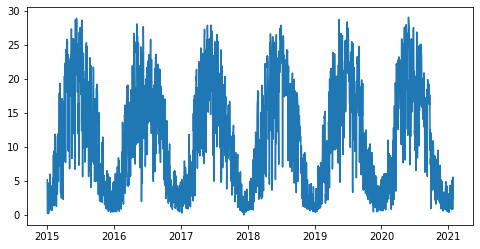

In [4]:
data_rescaled, k_factors = pre.rescaling(data, period_rescaling=365) 
#multiplot(data_rescaled, time, 2016)
     
med = pre.median(data_rescaled)
fig = plt.figure(figsize=(8.0, 4.0))
plt.plot(time, med); plt.show()

Now that we estimated $c$, we can remove it from the (raw) data:

$$ \hat \eta(i,t) \hat \chi(i,t)= \frac{P(i,t)} {\hat c(t)}. $$

To this end, we use the function ``remove_signal()``. As most of the functions in the package, its first argument is the data. The second argument of the function is set here to ``model = 'multiplicative'``. With this setting, the common signal is divided from the data whereas it would have been subtracted if ``model='additive'``. The third argument of the function allows the specification of the common signal. By default, it is computed as the median of the data. Here, it is specified as the median of the rescaled data instead, ``ref=med``. 

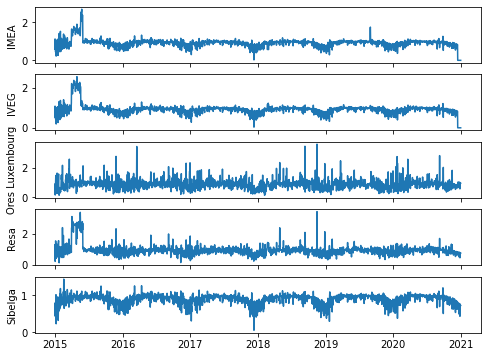

In [5]:
ratio = pre.remove_signal(data, ref=med, model='multiplicative') 
multiplot(ratio, time)

After rescaling once again the data, we obtain finally an estimation of the mean of the localized variations, $\eta$, that will be denoted by $\hat \mu_{\eta}(i,t)$ in the following:

$$ \hat \mu_{\eta}(i,t) = \frac{P(i,t)} {\hat c(t) \hat \chi(i,t)}. $$

In practice, we thus apply once more time the function ``rescaling()`` on the previous ratio to eliminate the level ($\chi$) of the data.

This variable will then be monitored in the following.

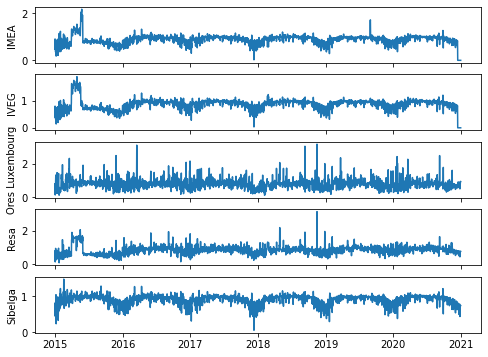

In [6]:
ratio, chi_factors = pre.rescaling(ratio, period_rescaling=365) 
multiplot(ratio, time)

## Phase I SPC: Estimation of the regular patterns

In the first stage of the method, we select a subset of in-control (IC) series from the panel.  We then estimate the mean and variance on those IC data along time. The data from the whole panel (in-control or out-of-control) are later standardised by these parameters.

### Selection of the pool of IC series

First, a subset (also called 'pool' in the following) of IC or stable series is selected from the network. 
To this end, a robust version of the MSE is computed for each series with the function ``pool_clustering()``. 
The series are then clustered in two groups based on their MSE value with the k-means algorithm <a id="ref-1" href="#cite-Lloyd1957">(Lloyd 1957)</a> and the subset with the lowest values is selected as the IC group.

In [7]:
### Selection of the IC pool 
pool = pre.pool_clustering(ratio) 
names_IC = [names[i] for i in range(n_series) if i in pool]
print('IC : ', names_IC)
names_OC = [names[i] for i in range(n_series) if i not in pool]
print('OC : ', names_OC)

IC :  ['IVEKA', 'Intergem', 'Iverlek', 'Ores Brabant wallon', 'Ores Hainaut', 'PBE', 'Regie de Wavre', 'Sibelga', 'Sibelgas']
OC :  ['AIEG', 'AIESH', 'Gaselwest', 'IMEA', 'IVEG', 'Imewo', 'Infrax West', 'Inter-Energa', 'Ores Est', 'Ores Luxembourg', 'Ores Mouscron', 'Ores Namur', 'Ores Verviers', 'Resa']


### Standardisation

Then, the (IC and OC) series are standardised by time-varying mean and variance. These quantities are computed across the pool of IC stations and along the time using K nearest neighbors regression method. Hence, the mean and the variance are always computed on the same number of values (=$K$) even if the data contain missing values. <br>

To this end, we first select the value of $K$ with the function ``choice_K()`` to obtain the 'best' standardisation of the complete panel, in the sense that its empirical mean becomes close to zero and its empirical variance close to one. This function computes the mean and standard deviation (std) of the standardised data for different values of $K$. Usually, the mean and std exhibit a similar behaviour: the mean comes closer to zero and the std draws near one with increasing values of $K$, as can be seen below. $K$ is thus selected as the knee of the std curve. <br>
The function ``choice_K()`` has several arguments: 
- ``data`` : the data from the whole panel 
- ``data_IC`` : the data from the IC pool only
- ``start`` : starting value for $K$ 
- ``stop`` : stopping value for $K$
- ``step`` : step value for $K$ <br>
The different values of $K$ are thus contained in the range [``start``, ``stop``] with a certain ``step``. <br>

Finally, the data from the whole panel (IC and OC) are standardised by the IC mean and variance using the function ``standardisation()``. This function has three mandatory arguments: 
 
- ``data`` : the data from the whole panel 
- ``data_IC`` : the data from the IC pool only
- ``K`` : the number of nearest neighbours.


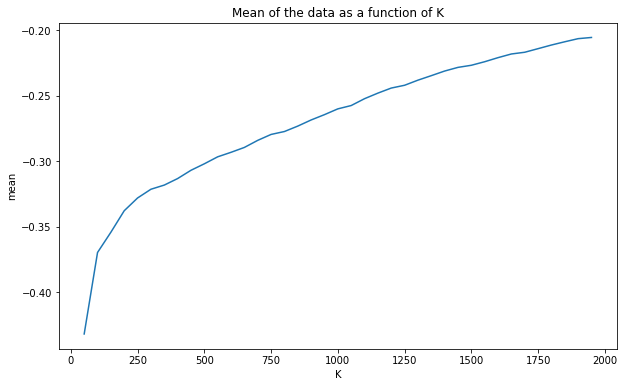

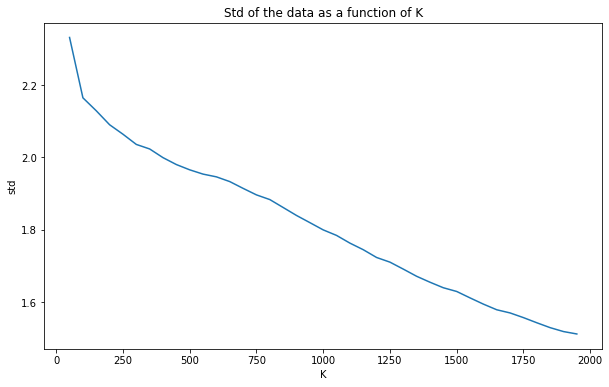

K : 400


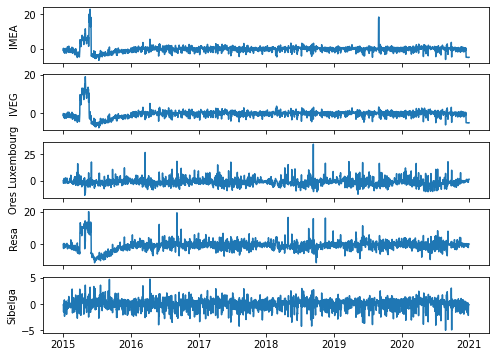

In [8]:
### Choice of K 
ratioIC = ratio[:, pool]

### standardise the data
K_knee = pre.choice_K(ratio, ratioIC, start=50, stop=2000, step=50)
print('K :', K_knee)
data_stn, dataIC_stn = pre.standardisation(ratio, ratioIC, K_knee)
multiplot(data_stn, time)

###  Histogram of the standardised data

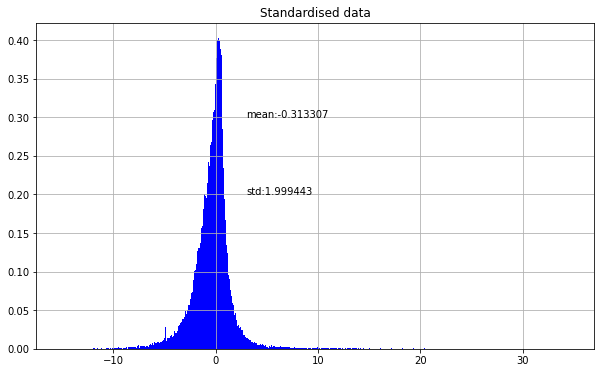

In [9]:
### plot all data
plt.hist(data_stn[~np.isnan(data_stn)], bins='auto', density=True, facecolor='b')  
plt.title("Standardised data")
plt.text(3, 0.3, 'mean:' '%4f' %np.nanmean(data_stn))
plt.text(3, 0.2, 'std:' '%4f' %np.nanstd(data_stn))
plt.grid(True)
plt.show()

## Phase II SPC: Monitoring

Having selected an IC pool and standardised the data by the IC mean and variance, we can now move on to the second phase of the method. <br>
In this stage, we calibrate the CUSUM chart on the data using the block bootstrap (BB), a procedure that randomly samples blocks of observations with repetition from the data to generate new series similar to the observations.

### Choice of the block length

To calibrate the CUSUM chart, we first select an appropriate value for the block length. This length depends on the autocorrelation of the data and can be automatically selected using the function ``block_length_choice()``.
Large blocks usually better model the autocorrelation of the data but at the same time do not represent well the variance and the mean of the series. And conversely. Therefore, we compute an appropriate value for the block length by the following procedure. <br>
For each block length tested, we resample several series of observations using a block bootstrap procedure. Then, the mean squared error (mse) of the mean, standard deviation and autocorrelation are computed on
the resampled series (with respect to the original data). The appropriate value for the block length is finally selected as the knee of the autocorrelation curve. <br>
Intuitively, this length corresponds to the first value such that the main part of the autocorrelation of the series is well represented. <br>

The function ``block_length_choice()`` contains the main following arguments (for more info look directly at the documentation on top of the function): 
- ``data`` : the IC data 
- ``bbl_min`` : starting value for the block length (here set to 1)
- ``bbl_max`` : upper value for the block length (here set to 50)
- ``bbl_min`` : step value for the block length (here set to 1) <br>
The different values for the block length are thus contained in the range [``bbl_min``, ``bbl_max``] with step value ``bbl_step``.

In [10]:
bb_length = acf.block_length_choice(dataIC_stn, 1, 50, 1) 
print('Block length: ', bb_length)

KeyboardInterrupt: 

### Choice of  the target shift size

The target shift size that it is interesting to detect depends on the deviations that the series experience. <br>
This parameter may be estimated recursively with the function ``shift_size()`` as follows. 
For an initial value of the shift size, we compute the control limits of the chart. Then, the chart is applied on out-of-control series and the size of the deviations is estimated after each alert using a classical formula <a id="ref-2" href="#cite-Montgomery2005">(Montgomery 2005)</a>. This formula is only valid for iid normal observations however it may still be used as a first approximation (the real shift sizes will be predicted later using a support vector regressor). 
Then, the value of the shift size is updated such as a specified quantile of the shift sizes distribution. 
The procedure is then iterated until the shift size converges. <br>
Since the shift sizes are expected to variate over a wide range, we select the target value as the 0.4 quantile of the shift sizes distribution.
<br>

The function ``shift_size()`` contains the main following arguments: 
- ``data`` : the data from the whole panel
- ``pool`` : the index of the IC series in the panel
- ``delta`` : the initial value for the target shift size 
- ``ARL0_threshold`` : the pre-specified value of the average run length (ARL0). <br>
This value controls the rate of false positives (the rate of false positivse is inversely proportional to the ARL0). It is set to 200.
- ``block_length`` : the length of the blocks 
- ``qt`` : the quantile of the shift sizes distribution 
- ``missing_values`` : policy to treat the missing values. <br>
The missing values policy is set to 'omit'. In this mode, the chart is calculated on data that do not contain missing observations. 

In [ ]:
bb_length = 8
delta_init = 2 #intial value for the target shift size
ARL0 = 200 #pre-specified ARL0 (controls the false positives rate)

### estimate an appropriate shift size 
delta_target = chart.shift_size(data_stn, pool, delta=delta_init, ARL0_threshold=ARL0, block_length=bb_length, 
                 qt=0.4, missing_values ='omit')[1]
print('delta target: ', delta_target)

###  Control limit of the chart.

Having selected the block length and the target shift size, the control limits of the CUSUM chart can finally be adjusted on the IC series.
To this end, we use the function ``limit_CUSUM()``, which adjusts the limits until a pre-specified value for the rate of false positive (ARL0) is reached at a desired accuracy. <br>

The function ``limit_CUSUM()`` contains the main following arguments: 
- ``dataIC`` : the IC data 
- ``delta`` : the target shift size 
- ``ARL0_threshold`` : the pre-specified value of the average run length (ARL0). <br>
This value controls the rate of false positives (the rate of false positivse is inversely proportional to the ARL0). It is set by default to 200.
- ``L_plus`` : the upper value of the searching interval 
- ``block_length`` : the length of the blocks 
- ``missing_values`` : policy to treat the missing values. <br>
The missing values policy is set to 'omit'. In this mode, the chart is calculated on data that do not contain missing observations. 

The function returns the positive value for the control limit. The negative limit has the same value as the positive one with opposite sign since the distribution of the data is (almost) symmetric. 

In [ ]:
delta_target = 2
control_limit = chart.limit_CUSUM(dataIC_stn, delta=delta_target, L_plus=4,
                 block_length=bb_length, missing_values='omit') 


## Phase III: Estimation of shift sizes and shapes using SVMs

In this third and last phase of the monitoring method, the support vector machines (SVM) for extracting and classifying out-of-control patterns are designed. Those methods are composed of a support vector regressor (SVR) to predict the size of the shifts in a continuous range and a support vector classifier (SVC) to classify the shape of the encountered deviations among a pre-defined number of classes.

### Selection of the length of the input vector

To this end, we first select the length of the input vector of the SVMs. 
It represents the number of past observations that are fed to the support vector classifier and regressor after each alert. The regressor and classifier then predict the form and the size of the shift that causes the alert based on this vector.  
Hence, the length should be sufficiently large to ensure that most of the shifts are contained within the input vector while maintaining the computing efficiency of the method. This is usually not a problem for the large shifts that are quickly detected by the chart. However the smallest shifts may be detected only after a certain amount of time and therefore require large vectors. <br>
Hence, the length is selected as an upper quantile of the run length distribution, computed on data shifted by the smallest shift size that we aim to detect. <br>

To select this length, we can use the function ``wdw_length()``. It works as follows.  <br>
For each monte-carlo run, a new series of observations is sampled from the IC data using a block bootstrap procedure. Then, a jump of size ``delta_min`` is simulated on top of the sample. The run length of the chart is then evaluated. The length of the input vector is finally selected as a specified upper quantile (quantile >=0.5) of the run length distribution. If the quantile is unspecified, an optimal quantile is selected by locating the 'knee' of the quantiles curve.  <br>

The function ``wdw_length()`` has the following main arguments: 
- ``data`` : the IC standardised data 
- ``delta_min`` : the target shift size 
- ``L_plus`` : the value of the positive control limit 
- ``block_length`` : the length of the blocks 
- ``qt`` : the specified upper quantile

In [ ]:
wdw_length = svm.input_vector_length(dataIC_stn, delta_target, control_limit,
                                block_length=bb_length, qt=0.95);
print('wdw_length: ', wdw_length)

###  Choice of the regularization parameter

The regularization parameter ($\lambda$) represents the trade-off between misclassification and regularization.
It may be automatically selected with the function ``choice_C()``. 
This function selects $\lambda$ (sometimes called $C$ in the literature) to maximize the performance of the SVM classifier and regressor.
To this end, it trains the classifier and regressor on simulated deviations for different values of $\lambda$ in the range [`` start``, ``stop``] with a certain `` step``.
The function then returns the values of $\lambda$ that maximizes the accuracy for the classifier, the mean squared error (MSE) and the mean absolute percentage error (MAPE) for the regressor. <br>

This function contains the main following arguments: 

- ``data`` : the IC standardised data 
- ``L_plus`` : the value of the positive control limit 
- ``delta`` : the target shift size 
- ``wdw_length`` : the length of the input vector 
- ``scale`` : the scale parameter of the half-normal distributions that are used to randomly select the sizes of the artificial deviations.
- ``start`` : starting value for $\lambda$ 
- ``stop`` : stopping value for $\lambda$ 
- ``step`` : step value for $\lambda$ 
The different values of $\lambda$ are thus contained in the range [``start``, ``stop``] with a certain ``step``. <br>
- ``delay`` : flag to start the monitoring after a random delay in the range [0, ``delay``]
- ``block_length`` : the length of the blocks 
- ``confusion`` : flag to print the confusion matrix

In [ ]:
wdw_length = 10 
scale = 4

### find an optimal value for the regularization parameter
C_choices = svm.choice_C(dataIC_stn, control_limit, delta_target, wdw_length, scale,
                     start = 1, stop = 11, step = 1,
               delay=2*wdw_length, block_length=bb_length, confusion=False)

### Training and validation of the SVMs

Having defined the three main parameters of the SVM procedures, we can now train the classifier and regressor on artificial deviations. 
Those are obtained as follows. After randomly sampling series of IC data by a BB procedure, three types of artificial deviations of size $\delta$ are added top of those series: 

- jumps: $x(t) = x_{ic}(t)+\delta$ ;
- drifts (with varying power-law functions) : $x(t) = x_{ic}(t)+\frac{\delta}{T'}(t)^{a}$, where $a$ is randomly selected in the range $[1.5, 2]$ ;
- oscillating shifts (with different frequencies): $x(t) = x_{ic}(t) \delta \sin{(\eta \pi t)}$, where $\eta$ is randomly selected in the range $[\frac{\pi}{m}, \frac{3\pi}{m}]$. <br>

In practice, the function ``training_svm()`` does both the training and the testing of the classifier and regressor. It has the same mandatory arguments as the function ``choice_C()`` that we see previously. It has also an optional argument,  ``C``, that allows the user to specify to the value of the parameter $\lambda$.

In [ ]:
#train the classifier and regressor with selected C
C = 4 
reg, clf = svm.training_svm(dataIC_stn, control_limit, delta_target,
                wdw_length, scale, delay=wdw_length*2, C=C, block_length=bb_length)


In [ ]:
### save models 
# filename = 'svr_elia_daily.sav'
# pickle.dump(reg, open(filename, 'wb'))
# filename = 'svc_elia_daily.sav'
# pickle.dump(clf, open(filename, 'wb'))

In [ ]:
### or load the models previously trained
#reg = pickle.load(open('../svm_models/svr_elia_daily.sav', 'rb'))
#clf = pickle.load(open('../svm_models/svc_elia_daily.sav', 'rb'))

## Monitoring and results display

In the previous sections, we adjust the parameters of the CUSUM chart and train the SVM methods on the photovoltaic energy production data. 
We will now apply the method that is fully calibrated to actually monitor those data.

The function ``alerts_info()`` can be used to apply the complete procedure (CUSUM chart plus SVM methods) on a particular series of the panel.
It contains the main following arguments: 
- ``data`` : a standardised series to be monitored
- ``L_plus`` : the value of the positive control limit 
- ``delta`` : the target shift size 
- ``wdw_length`` : the length of the input vector 
- ``clf`` : the trained classifier 
- ``reg`` : the trained regressor 

Six quantities are returned by the function: the positive and negative shapes of the shifts (``form_plus`` and `` form_minus``), sizes of the shifts (``size_plus`` and ``size_minus``) and chart statistics (``C_plus`` and `` C_minus``).  When the series is not in alert, the sizes and forms of the shifts are set to ``NaN``. <br>
The function has also an optional argument ``cut``, which is set by default to ``2L_plus``. This argument defines the maximal value that the chart statistics are allowed to take, i.e. $|C^+_j|$, $|C^-_j| \leq 2L$. It thus prevents the chart to take too high values and therefore stay in alert for longer periods than the actual deviations of the series. 

Then, diverse functions can be called to display the main features of the monitoring.  
The function ``plot_3panels()`` returns a plot composed of three panels, which shows respectively (1) the standardised series of data which is analysed, (2) the CUSUM chart statistics ($|C^+|$, $|C^-|$) and (3) the shapes and sizes of the shifts that are predicted by the SVM when the chart is in alert.
The function has the main following arguments: 

- ``data`` : a standardised series to be monitored
- ``L_plus`` : the value of the positive control limit 
- ``time`` : an array with the time of the observations
- ``form_plus``, ``form_minus`` : the predicted shift forms by SVMs
- ``size_plus``, ``size_minus`` : the predicted shift sizes by SVMs
- ``C_plus``, ``C_minus`` : the CUSUM statistics
- ``name`` : the code name of the series
- ``time_start`` : the starting time value of the figure
- ``time_stop`` : the stoping time value of the figure
- ``x_ticks`` : the locations of the ticks for the x-axis of the figure
- ``labels_ticks`` : the labels of the ticks for the x-axis of the figure
The labels can only be passed if the locations are passed as well.
- ``fig_size`` : the width and heigth of the figure

In [ ]:
region = [i for i in range(len(names)) if names[i] == 'Resa'][0]

for i in range(region, region+1): 
    
    data_indv = data_stn[:,i] #monitored series
    
    [form_plus, form_minus, size_plus, size_minus,
    C_plus, C_minus] = appl.alerts_info(data_indv, control_limit, 
            delta_target, wdw_length, clf, reg)
                                  
    fig = appl.plot_3panels(data_indv, control_limit, time, 
                      form_plus, form_minus, size_plus, size_minus, 
                      C_plus, C_minus, names[i], time_start=2015,
                      time_stop=2021)
    
    fig = appl.plot_4panels(data_indv, ratio[:,i], control_limit, time, 
                  form_plus, form_minus, size_plus, size_minus, 
                 C_plus, C_minus, names[i], time_start=2015,
                  time_stop=2021)
        
    fig = appl.plot_1panel(data_indv, time, 
              form_plus, form_minus, size_plus, size_minus, names[i],
              time_start=2016, time_stop=2017)


In [ ]:
region = [i for i in range(len(names)) if names[i] == 'Resa'][0]

# time in form of dates
dates = np.arange(datetime(2015, 1, 1), datetime(2021, 1, 27), 
                  timedelta(days=1)).astype(datetime)
#x_ticks
dates_months =  []
dates_months.append(datetime(2015, 1, 1))
while dates_months[-1] < datetime(2016, 1, 1):
    dates_months.append(dates_months[-1] + relativedelta(months=3))
x_ticks = dates_months

#labels of x_ticks
lab_ticks = []
for i in range(len(x_ticks)):
    lab_ticks.append(x_ticks[i].strftime('%d-%b'))
    
for i in range(region, region+1): 
    
    data_indv = data_stn[:,i] #monitored series
    
    [form_plus, form_minus, size_plus, size_minus,
    C_plus, C_minus] = appl.alerts_info(data_indv, control_limit, 
            delta_target, wdw_length, clf, reg)
                                  
                                        
    fig = appl.plot_3panels(data_indv, control_limit, dates, 
                      form_plus, form_minus, size_plus, size_minus, 
                      C_plus, C_minus, names[i], time_start=datetime(2015,1,1), 
                      time_stop=datetime(2016,1,1), x_ticks=x_ticks, 
                      labels_ticks=lab_ticks)   

<!--bibtex

@ARTICLE{Mathieu2019,
    AUTHOR={{Mathieu}, S. and {von Sachs}, R. and {Delouille}, V. and {Lefevre}, L. and {Ritter}, C.},
    TITLE="{Uncertainty quantification in sunspot counts}",
    JOURNAL={The Astrophysical Journal},
    YEAR={2019}, 
	volume = {886},
	number={1}, 
	pages= {}, 
	doi={https://doi.org/10.3847/1538-4357/ab4990}
}


@article{Kruskal_Wallis,
    author = {{Kruskal}, W. and {Wallis}, W.},
    title ="{Use of ranks in one-criterion variance analysis}",
    journal = {Journal of the American Statistical Association},
    volume = {47},
    number = {260},
    pages = {583-621},
    year = {1952},
    doi = {10.1191/1471082X04st068oa},
    URL = {https://www.jstor.org/stable/2280779}
}

@ARTICLE{Qiu2014,
    author={{Qiu}, P. and {Xiang}, D.},
    title = "{Univariate dynamic screening system: an approach for identifying individuals with irregular longitudinal behaviour}",
    journal = {Technometrics},
	volume = {56},
    number = {2},
    pages = {248-260},
    year = {2014},
	doi = {https://doi.org/10.1080/00401706.2013.822423},
    issn = {0040-1706}
}

@BOOK{Montgomery2005,
   author = {{Montgomery}, D},
   title = "{Introduction to Statistical Quality Control}",
   publisher={Wiley},
   year = {2004},
   edition = {5th}
}

@TechReport{Lloyd1957,
    author={{Lloyd}, S.P. },
    title = "{Least squares quantization in PCM}",
    institution = {Bell Lab},
    year = {1957},
    type = {Technical Report RR-5497},
    number = {5497}
}



@ARTICLE{Cheng2011,
    author={{Cheng}, C-S. and {Chen}, P-W. and {Huang}, K-K. },
    title = "{Estimating the shift size in the process mean with support vector regression and neural network}",
    journal = {Expert Systems with Applications},
    year = {2011},
	volume={38},
	number={8},
	pages={10624-10630},
	doi = {https://doi.org/10.1016/j.eswa.2011.02.121}
}


-->


<!--bibtex

@ARTICLE{Mathieu2019,
    AUTHOR={{Mathieu}, S. and {von Sachs}, R. and {Delouille}, V. and {Lefevre}, L. and {Ritter}, C.},
    TITLE="{Uncertainty quantification in sunspot counts}",
    JOURNAL={The Astrophysical Journal},
    YEAR={2019}, 
	volume = {886},
	number={1}, 
	pages= {}, 
	doi={https://doi.org/10.3847/1538-4357/ab4990}
}


@article{Kruskal_Wallis,
    author = {{Kruskal}, W. and {Wallis}, W.},
    title ="{Use of ranks in one-criterion variance analysis}",
    journal = {Journal of the American Statistical Association},
    volume = {47},
    number = {260},
    pages = {583-621},
    year = {1952},
    doi = {10.1191/1471082X04st068oa},
    URL = {https://www.jstor.org/stable/2280779}
}

@article{Page1961,
author = {{Page}, E. S.},
title ="{Cumulative sum charts}",
journal = {Technometrics},
volume = {3},
number = {1},
pages = {1-9},
year = {1961},
URL = {https://www.jstor.org/stable/1266472}
}
-->


# References

<a id="cite-Lloyd1957"/><sup><a href=#ref-1>[^]</a></sup>Lloyd, S.P. . 1957. _Least squares quantization in PCM_.

<a id="cite-Montgomery2005"/><sup><a href=#ref-2>[^]</a></sup>Montgomery, D. 2004. _Introduction to Statistical Quality Control_.

